In [1]:
import numpy as np # thư viện tính toán số học
import pandas as pd # thư viện giúp đọc file và xử lí dữ liệu dạng bảng
import yfinance as yf # thư viện lấy dữ liệu
import tensorflow as tf # thư viện model
from tensorflow.keras.models import Sequential # Sắp xếp các lớp
from tensorflow.keras.layers import Layer, LSTM, Dense, Dropout # Các lớp sử dụng trong mô hình
from sklearn.preprocessing import MinMaxScaler # Chuẩn hóa dữ liệu
from sklearn.metrics import mean_squared_error # Tính độ lỗi
import matplotlib.pyplot as plt # Thư viện vẽ đồ thị
import random # random

In [2]:
# Tải dữ liệu 10 năm dùng thư viện yfinance
def download_stock_data(ticker, staperiod="10y", interval="1d"):
    data = yf.download(ticker, period="10y", interval="1d")
    return data


In [3]:
# Ví dụ về 1 mã cổ phiếu
data = download_stock_data("AAPL")
# Đảm bảo dữ liệu là của các ngày liên tục ('D': daily),
# các ngày không có dữ liệu (T7,CN) thì giá trị dữ liệu được gán NaN
data = data.asfreq('D')

# Kiểm tra 10 dòng đầu để đảm bảo không sót ngày nào
data.tail(10)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2025-05-20,206.860001,208.470001,205.029999,207.669998,42496600.0
2025-05-21,202.089996,207.039993,200.710007,205.169998,59211800.0
2025-05-22,201.360001,202.750000,199.699997,200.710007,46742400.0
2025-05-23,195.270004,197.699997,193.460007,193.669998,78432900.0
2025-05-24,NaN,NaN,NaN,NaN,NaN
2025-05-25,NaN,NaN,NaN,NaN,NaN
2025-05-26,NaN,NaN,NaN,NaN,NaN
2025-05-27,200.210007,200.740005,197.429993,198.300003,56288500.0


In [4]:
# fillna() là hàm dùng để ghi đè các ô có giá trị NaN
# method='ffill' (forward fill) nghĩa là: Nếu một ô có giá trị NaN,
# hãy lấy giá trị ở dòng phía trên nó để điền vào ()
data = data.fillna(method='ffill')

# Kiểm tra 10 dòng đầu để đảm bảo không còn giá trị NaN nào.
data.tail(10)

C:\Users\admin\AppData\Local\Temp\ipykernel_11328\410669001.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2025-05-20,206.860001,208.470001,205.029999,207.669998,42496600.0
2025-05-21,202.089996,207.039993,200.710007,205.169998,59211800.0
2025-05-22,201.360001,202.750000,199.699997,200.710007,46742400.0
2025-05-23,195.270004,197.699997,193.460007,193.669998,78432900.0
2025-05-24,195.270004,197.699997,193.460007,193.669998,78432900.0
2025-05-25,195.270004,197.699997,193.460007,193.669998,78432900.0
2025-05-26,195.270004,197.699997,193.460007,193.669998,78432900.0
2025-05-27,200.210007,200.740005,197.429993,198.300003,56288500.0


In [5]:
# Lấy ra duy nhất cột giá đóng cửa (Close) –
# đây là dữ liệu quan trọng nhất trong phân tích tài chính và dự báo.
close_prices = data[['Close']]

# Kiểm tra 10 giá trị đầu của chuỗi Close, để đảm bảo dữ liệu được lọc đúng.
close_prices.tail(10)

Price,Close
Ticker,AAPL
Date,
2025-05-20,206.860001
2025-05-21,202.089996
2025-05-22,201.360001
2025-05-23,195.270004
2025-05-24,195.270004
2025-05-25,195.270004
2025-05-26,195.270004
2025-05-27,200.210007


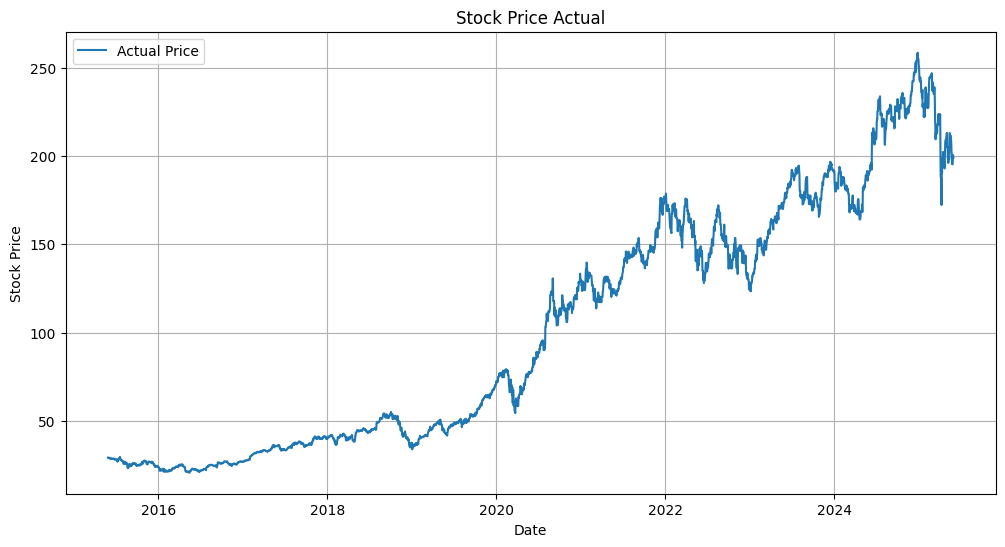

In [6]:
# Vẽ đồ thị giá thực
dates = data.index[:]
plt.figure(figsize=(12, 6))
plt.plot(dates, close_prices, label='Actual Price')
plt.title('Stock Price Actual')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
def directional_loss(y_true, y_pred):
    diff_true = y_true[:, 1:] - y_true[:, :-1]
    diff_pred = y_pred[:, 1:] - y_pred[:, :-1]
    return tf.reduce_mean(tf.maximum(0.0, -diff_true * diff_pred))  # penalize opposite direction

def combined_loss(y_true, y_pred):
    alpha = 0.4  # trọng số cho directional loss
    beta = 0.2   # trọng số cho underprediction penalty

    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    dir_loss = directional_loss(y_true, y_pred)

    under_penalty = tf.reduce_mean(tf.nn.relu(y_true - y_pred))  # chỉ phạt khi dự đoán thấp hơn thực tế

    return mse + alpha * dir_loss + beta * under_penalty

In [8]:
# Step 3.2: Build LSTM model using library
def build_model(input_shape, units=50, output_steps=5):
    model = Sequential()
    model.add(LSTM(units, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(output_steps))  # Output shape = (batch_size, k)
    model.compile(optimizer='adam', loss= combined_loss)
    return model

In [9]:
# Prepare data
def create_dataset(data, window_size=60, k=5):
    X, y = [], []
    for i in range(window_size, len(data) - k + 1):  # ensure enough room for k steps
        X.append(data[i - window_size:i])
        y.append(data[i:i + k].flatten())  # output is a sequence of k steps
    return np.array(X), np.array(y)

In [10]:
# Lấy dữ liệu gốc
close_prices = data['Close'].values.reshape(-1, 1)
total_len = len(close_prices)

# Chia theo 80% train, 10% val, 10% test
train_end = int(0.8 * total_len)
val_end = int(0.9 * total_len)

# ⚠️ Giữ lại 90 ngày trước khi chia để đủ cho mọi window_size
max_window_size = 180
train_raw = close_prices[:train_end]
val_raw = close_prices[train_end - max_window_size:val_end]
test_raw = close_prices[val_end - max_window_size:]

# Chuẩn hóa
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_raw)
val_scaled = scaler.transform(val_raw)
test_scaled = scaler.transform(test_raw)


In [ ]:
def particle_swarm_optimization(population_size=10, max_generations=30,patience=5, target_mse=0.001, no_improve_count=0, w_max=0.9, w_min = 0.4, k=5):
    # 1. Tạo cá thể ngẫu nhiên (tọa độ và vận tốc)
    def create_particle():
        position = {
            'window_size': random.randint(30, 180),
            'units': random.choice([32, 64, 128])
        }
        velocity = {
            'window_size': random.uniform(-10, 10),
            'units': random.choice([-32, 0, 32])
        }
        return {
            'position': position,
            'velocity': velocity,
            'best_position': position.copy(),
            'best_score': float('inf')
        }

    # 2. Tính fitness
    def fitness(ind):
        window_size = int(round(ind['position']['window_size']))
        units = int(ind['position']['units'])

        # Giới hạn window_size nằm trong [30, 90] và units nằm trong {32, 64, 128}
        window_size = min(90, max(30, window_size))
        units = min([32, 64, 128], key=lambda x: abs(x - units))

        # Tạo dataset từ tập đã chia & chuẩn hóa
        X_train, y_train = create_dataset(train_scaled, window_size, k)
        X_val, y_val = create_dataset(val_scaled, window_size, k)

        model = build_model((window_size, 1), units=units, output_steps=k)
        model.fit(X_train, y_train, epochs=3, batch_size=32, verbose=0)
        preds = model.predict(X_val)

        mse = mean_squared_error(y_val, preds)
        return mse, window_size, units


    # 3. Khởi tạo quần thể
    swarm = [create_particle() for _ in range(population_size)]
    global_best_position = None
    global_best_score = float('inf')
    best_score_history = float('inf')

    for gen in range(max_generations):
        print(f"\nLoop {gen+1}")
        w = w_max - (w_max - w_min) * gen / max_generations
        c1 = 2.5 - 2 * (gen / max_generations)
        c2 = 0.5 + 2 * (gen / max_generations)
        for i, particle in enumerate(swarm):
            score, actual_ws, actual_units = fitness(particle)
            print(f"Particle {i+1}: window_size={actual_ws}, units={actual_units}, MSE={score:.6f}")

            if score < particle['best_score']:
                particle['best_score'] = score
                particle['best_position'] = particle['position'].copy()

            if score < global_best_score:
                global_best_score = score
                global_best_position = particle['position'].copy()

        # 4. Cập nhật vận tốc và vị trí
        for particle in swarm:
            for key in ['window_size', 'units']:
                r1 = random.random()
                r2 = random.random()
                cognitive = c1 * r1 * (particle['best_position'][key] - particle['position'][key])
                social = c2 * r2 * (global_best_position[key] - particle['position'][key])
                particle['velocity'][key] = w * particle['velocity'][key] + cognitive + social
                #particle['position'][key] += particle['velocity'][key]

                # 👉 Velocity Clamping (Giới hạn vận tốc)
                #v_max = {'window_size': 10, 'units': 32}
                #particle['velocity'][key] = max(-v_max[key], min(v_max[key], particle['velocity'][key]))

                particle['position'][key] += particle['velocity'][key]
                # Giới hạn window_size và units
                if key == 'window_size':
                    particle['position'][key] = min(180, max(30, particle['position'][key]))
                elif key == 'units':
                    # Chỉ cho phép gần các giá trị 32, 64, 128
                    raw_units = particle['position'][key]
                    particle['position'][key] = min([32, 64, 128], key=lambda x: abs(x - raw_units))
                    
        print(f"Best individual of generation {gen+1}: window_size={int(global_best_position['window_size'])}, units={int(global_best_position['units'])}, MSE={global_best_score:.6f}")

         # 🔸 Điều kiện dừng sớm
        if global_best_score < best_score_history:
            best_score_history = global_best_score
            no_improve_count = 0 #reset bộ đếm
        else:
            no_improve_count += 1

        if global_best_score <= target_mse:
            print(f"Early stopping: đạt MSE mục tiêu {target_mse} ở thế hệ {gen+1}.")
            break
        if no_improve_count >= patience:
            print(f"Early stopping: không cải thiện trong {patience} thế hệ.")
            break

    # Trả về kết quả tốt nhất
    final_window_size = int(round(global_best_position['window_size']))
    final_units = int(global_best_position['units'])
    print(f"\nFinal best individual: window_size={final_window_size}, units={final_units}, MSE={global_best_score:.6f}")
    return {'window_size': final_window_size, 'units': final_units}


In [ ]:
    # GA optimization
best_params = particle_swarm_optimization(k=5)
print("Best Parameters from PSO:", best_params)


Generation 1
15/15 [==============================] - 1s 16ms/step
Particle 1: window_size=90, units=32, MSE=0.002772
16/16 [==============================] - 1s 15ms/step
Particle 2: window_size=52, units=32, MSE=0.001227
15/15 [==============================] - 1s 12ms/step
Particle 3: window_size=90, units=32, MSE=0.009978
15/15 [==============================] - 1s 11ms/step
Particle 4: window_size=90, units=64, MSE=0.006334
15/15 [==============================] - 2s 20ms/step
Particle 5: window_size=90, units=128, MSE=0.003770
15/15 [==============================] - 1s 16ms/step
Particle 6: window_size=90, units=64, MSE=0.001804
15/15 [==============================] - 1s 17ms/step
Particle 7: window_size=90, units=128, MSE=0.001523
15/15 [==============================] - 1s 13ms/step
Particle 8: window_size=90, units=128, MSE=0.004554
15/15 [==============================] - 1s 15ms/step
Particle 9: window_size=65, units=32, MSE=0.001577
15/15 [==============================]

In [15]:
from keras.callbacks import EarlyStopping

# 1. Lấy dữ liệu gốc (chưa chuẩn hóa)
close_prices = data['Close'].values.reshape(-1, 1)

# 2. Chia dữ liệu theo tỉ lệ 80% train, 10% val, 10% test
total_len = len(close_prices)
train_end = int(total_len * 0.8)
val_end = int(total_len * 0.9)

train_prices = close_prices[:train_end]
val_prices = close_prices[train_end - best_params['window_size']:val_end]
test_prices = close_prices[val_end - best_params['window_size']:]  # giữ lại window_size ngày

# 3. Fit scaler trên tập train và transform cả 3 phần
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_prices)
scaled_val = scaler.transform(val_prices)
scaled_test = scaler.transform(test_prices)

# 4. Tạo dataset
k=5
X_train, y_train = create_dataset(scaled_train, best_params['window_size'], k)
X_val, y_val = create_dataset(scaled_val, best_params['window_size'], k)
X_test, y_test = create_dataset(scaled_test, best_params['window_size'], k)

# 5. Gộp train + val để train mô hình cuối cùng
X_final_train = np.concatenate([X_train, X_val])
y_final_train = np.concatenate([y_train, y_val])

# 6. Xây mô hình
model = build_model((best_params['window_size'], 1), best_params['units'])

# 7. EarlyStopping (monitor trên `loss` vì không có val)
early_stop = EarlyStopping(
    monitor='loss',
    patience=5,
    restore_best_weights=True
)

# 8. Huấn luyện trên train + val
model.fit(
    X_final_train, y_final_train,
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=[early_stop]
)

# 9. Dự đoán trên test set và tính RMSE
preds = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("✅ Test RMSE:", rmse)


Epoch 1/100
99/99 [==============================] - 8s 33ms/step - loss: 0.0186
Epoch 2/100
99/99 [==============================] - 3s 32ms/step - loss: 0.0055
Epoch 3/100
99/99 [==============================] - 3s 32ms/step - loss: 0.0045
Epoch 4/100
99/99 [==============================] - 3s 32ms/step - loss: 0.0039
Epoch 5/100
99/99 [==============================] - 3s 31ms/step - loss: 0.0034
Epoch 6/100
99/99 [==============================] - 3s 31ms/step - loss: 0.0035
Epoch 7/100
99/99 [==============================] - 3s 34ms/step - loss: 0.0031
Epoch 8/100
99/99 [==============================] - 3s 32ms/step - loss: 0.0030
Epoch 9/100
99/99 [==============================] - 3s 31ms/step - loss: 0.0025
Epoch 10/100
99/99 [==============================] - 3s 32ms/step - loss: 0.0027
Epoch 11/100
99/99 [==============================] - 3s 31ms/step - loss: 0.0027
Epoch 12/100
99/99 [==============================] - 3s 32ms/step - loss: 0.0023
Epoch 13/100
99/99 [=====

12/12 [==============================] - 0s 27ms/step


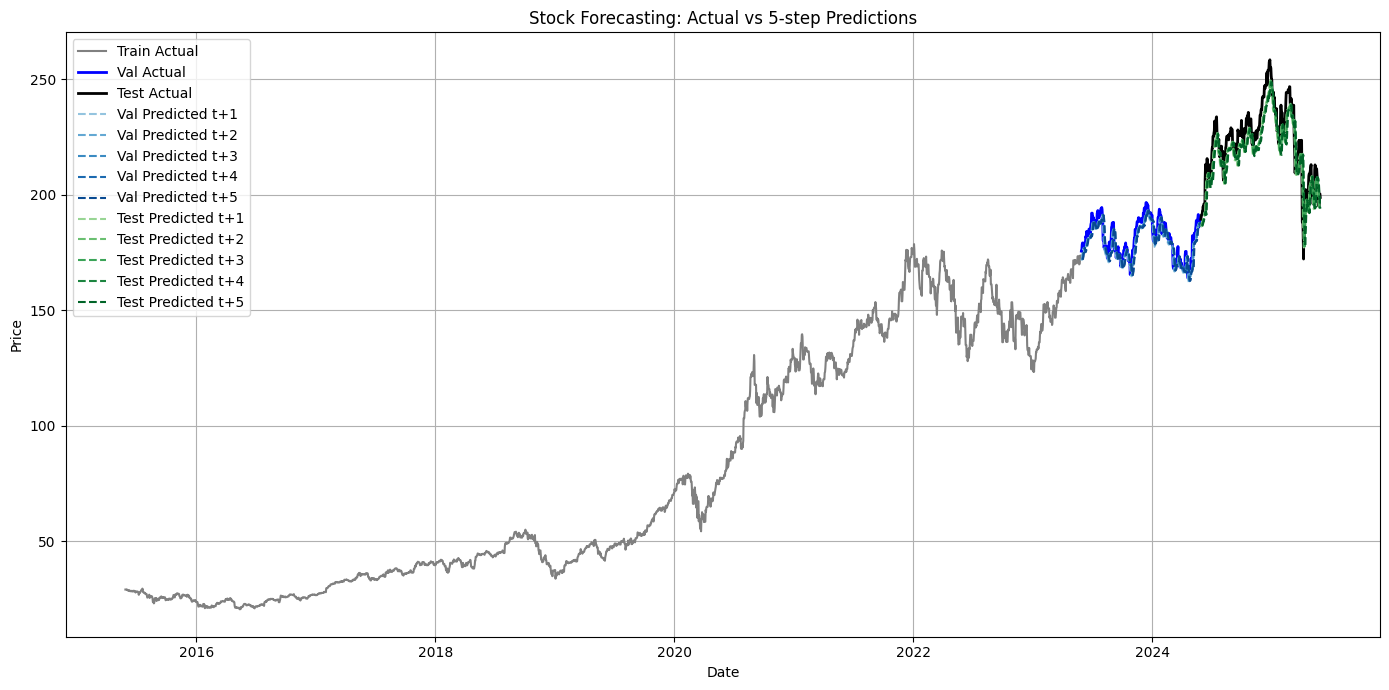

In [19]:
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
val_preds = model.predict(X_val)

def plot_all_forecasts(data, scaler, best_params, y_val, val_preds, y_test, test_preds):
    window_size = best_params['window_size']
    k = y_val.shape[1]

    total_len = len(data)
    train_end = int(0.8 * total_len)
    val_end = int(0.9 * total_len)

    # --- 1. Lấy index gốc ---
    train_dates = data.index[:train_end]

    val_start_index = train_end - window_size
    test_start_index = val_end - window_size

    # --- 2. Giải scale ---
    y_val_rescaled = scaler.inverse_transform(y_val.reshape(-1, 1)).reshape(y_val.shape)
    val_preds_rescaled = scaler.inverse_transform(val_preds.reshape(-1, 1)).reshape(val_preds.shape)

    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(y_test.shape)
    test_preds_rescaled = scaler.inverse_transform(test_preds.reshape(-1, 1)).reshape(test_preds.shape)

    # --- 3. Tạo dict giá thực ---
    def get_actual_dict(y_rescaled, start_idx):
        actual_dict = defaultdict(list)
        for i in range(len(y_rescaled)):
            start = start_idx + i + window_size
            for j in range(y_rescaled.shape[1]):
                date_idx = start + j
                if date_idx < len(data):
                    date = data.index[date_idx]
                    actual_dict[date].append(y_rescaled[i][j])
        return actual_dict

    actual_val = get_actual_dict(y_val_rescaled, val_start_index)
    actual_test = get_actual_dict(y_test_rescaled, test_start_index)

    # --- 4. Dự đoán từng bước ---
    def get_pred_lines(preds_rescaled, start_idx):
        pred_step_dict = [defaultdict(list) for _ in range(k)]
        for i in range(len(preds_rescaled)):
            start = start_idx + i + window_size
            for j in range(k):
                date_idx = start + j
                if date_idx < len(data):
                    date = data.index[date_idx]
                    pred_step_dict[j][date].append(preds_rescaled[i][j])
        pred_lines = []
        for j in range(k):
            common_dates = sorted(set(pred_step_dict[j].keys()))
            pred_avg = np.array([np.mean(pred_step_dict[j][d]) for d in common_dates])
            pred_lines.append((common_dates, pred_avg))
        return pred_lines

    val_pred_lines = get_pred_lines(val_preds_rescaled, val_start_index)
    test_pred_lines = get_pred_lines(test_preds_rescaled, test_start_index)

    # --- 5. Plot ---
    plt.figure(figsize=(14, 7))

    # Train thực tế
    plt.plot(train_dates, data['Close'][:train_end], label='Train Actual', color='gray', linewidth=1.5)

    # Val thực tế
    val_actual_dates = sorted(actual_val.keys())
    val_actual_avg = np.array([np.mean(actual_val[d]) for d in val_actual_dates])
    plt.plot(val_actual_dates, val_actual_avg, label='Val Actual', color='blue', linewidth=2)

    # Test thực tế
    test_actual_dates = sorted(actual_test.keys())
    test_actual_avg = np.array([np.mean(actual_test[d]) for d in test_actual_dates])
    plt.plot(test_actual_dates, test_actual_avg, label='Test Actual', color='black', linewidth=2)

    # Các bước dự đoán val
    colors = plt.cm.Blues(np.linspace(0.4, 0.9, k))
    for j, (dates, preds_j) in enumerate(val_pred_lines):
        plt.plot(dates, preds_j, label=f'Val Predicted t+{j+1}', color=colors[j], linestyle='--')

    # Các bước dự đoán test
    colors = plt.cm.Greens(np.linspace(0.4, 0.9, k))
    for j, (dates, preds_j) in enumerate(test_pred_lines):
        plt.plot(dates, preds_j, label=f'Test Predicted t+{j+1}', color=colors[j], linestyle='--')

    plt.title(f'Stock Forecasting: Actual vs {k}-step Predictions')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_all_forecasts(data, scaler, best_params, y_val, val_preds, y_test, preds)

12/12 [==============================] - 0s 34ms/step


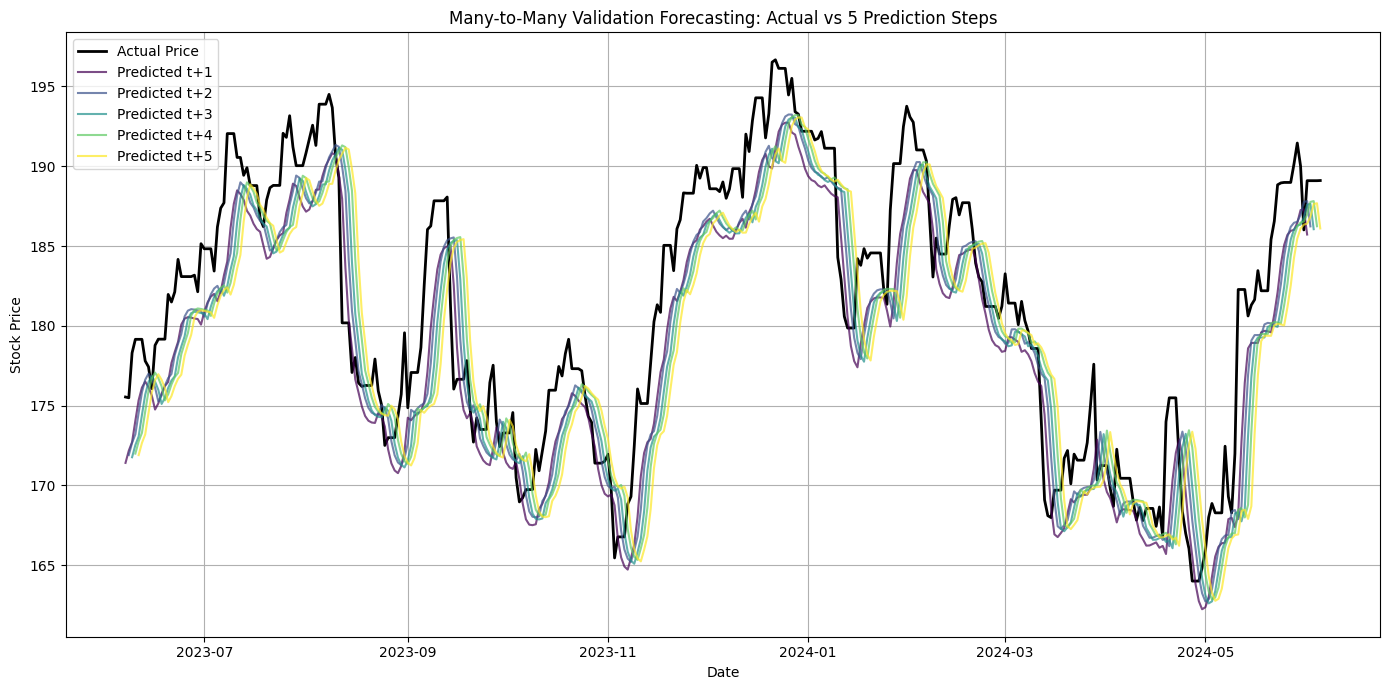

In [18]:
# Dự đoán trên tập validation
val_preds = model.predict(X_val)
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# 1. Rescale val ground truth và dự đoán
y_val_2d = y_val.reshape(-1, 1)
val_preds_2d = val_preds.reshape(-1, 1)

y_val_rescaled = scaler.inverse_transform(y_val_2d).reshape(y_val.shape)
val_preds_rescaled = scaler.inverse_transform(val_preds_2d).reshape(val_preds.shape)

# -------------------------------
# 2. Tạo actual_dict từ y_val_rescaled
actual_dict = defaultdict(list)
val_start_index = len(data) - len(y_test) - len(y_val) - best_params['window_size']

for i in range(len(y_val_rescaled)):
    start = val_start_index + i + best_params['window_size']
    for j in range(y_val_rescaled.shape[1]):
        date_idx = start + j
        if date_idx < len(data):
            date = data.index[date_idx]
            actual_dict[date].append(y_val_rescaled[i][j])

actual_dates = sorted(actual_dict.keys())
actual_avg = np.array([np.mean(actual_dict[d]) for d in actual_dates])

# -------------------------------
# 3. Dự đoán từng bước t+1, ..., t+k
k = val_preds_rescaled.shape[1]
pred_step_dict = [defaultdict(list) for _ in range(k)]

for i in range(len(val_preds_rescaled)):
    start = val_start_index + i + best_params['window_size']
    for j in range(k):
        date_idx = start + j
        if date_idx < len(data):
            date = data.index[date_idx]
            pred_step_dict[j][date].append(val_preds_rescaled[i][j])

# Trung bình từng bước
pred_lines = []
step_mae = []
for j in range(k):
    common_dates = sorted(set(pred_step_dict[j].keys()) & set(actual_dict.keys()))
    pred_avg = np.array([np.mean(pred_step_dict[j][d]) for d in common_dates])
    actual_avg_step = np.array([np.mean(actual_dict[d]) for d in common_dates])
    pred_lines.append((common_dates, pred_avg))
    step_mae.append(np.mean(np.abs(pred_avg - actual_avg_step)))

# -------------------------------
# 4. Plot
plt.figure(figsize=(14, 7))

# Đường thực tế
plt.plot(actual_dates, actual_avg, label='Actual Price', color='black', linewidth=2)

# Các đường dự đoán t+1 đến t+k
colors = plt.cm.viridis(np.linspace(0, 1, k))
for j in range(k):
    dates, preds_j = pred_lines[j]
    plt.plot(dates, preds_j, label=f'Predicted t+{j+1}', color=colors[j], alpha=0.7)

plt.title(f'Many-to-Many Validation Forecasting: Actual vs {k} Prediction Steps')
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


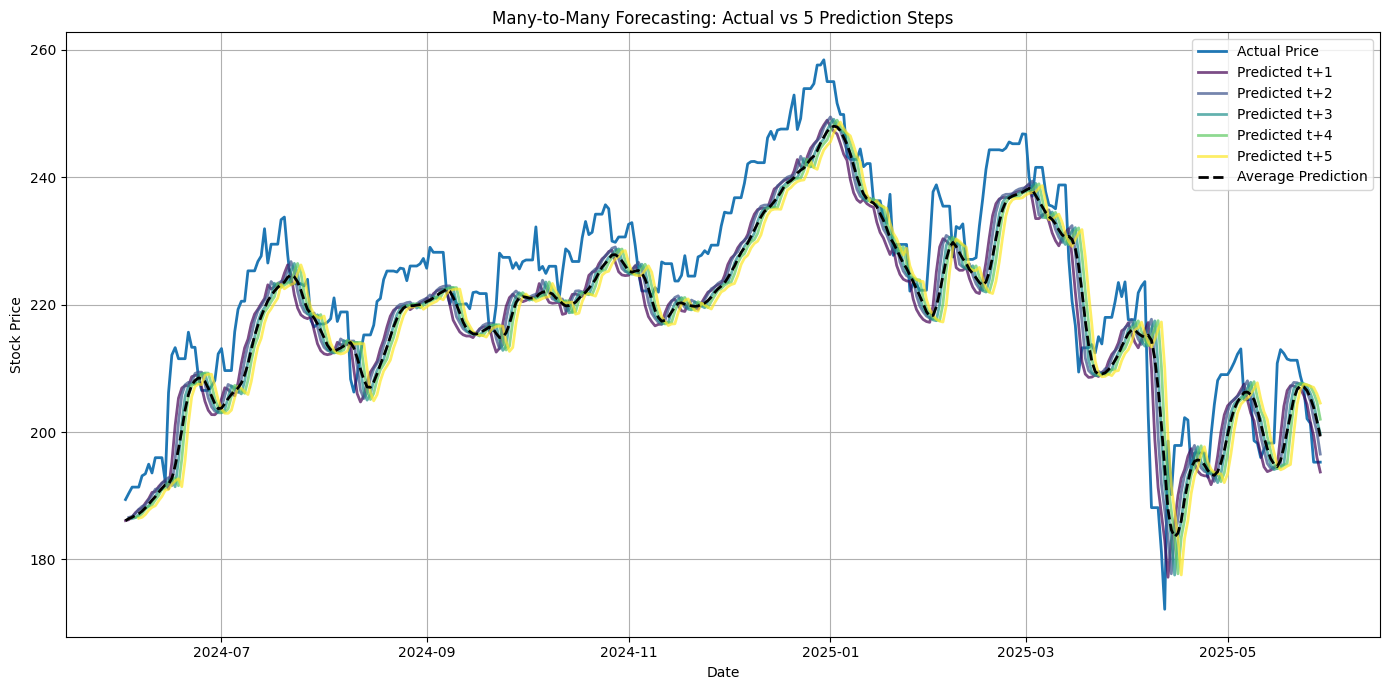

In [20]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

# Reshape cho inverse transform
y_test_2d = y_test.reshape(-1, 1)
preds_2d = preds.reshape(-1, 1)

y_test_rescaled = scaler.inverse_transform(y_test_2d).reshape(y_test.shape)
preds_rescaled = scaler.inverse_transform(preds_2d).reshape(preds.shape)

# ----------------------------
# Chuẩn bị actual price (trung bình nếu trùng)
actual_dict = defaultdict(list)
start_index = len(data) - len(y_test_rescaled) - best_params['window_size']

for i in range(len(y_test_rescaled)):
    start = start_index + i + best_params['window_size']
    for j in range(y_test_rescaled.shape[1]):
        date_idx = start + j
        if date_idx < len(data):
            date = data.index[date_idx]
            actual_dict[date].append(y_test_rescaled[i][j])

# Trung bình giá thực tế nếu trùng
actual_dates = sorted(actual_dict.keys())
actual_avg = np.array([np.mean(actual_dict[d]) for d in actual_dates])

# ----------------------------
# Dự đoán theo từng bước t+1, t+2, ..., t+k
k = preds_rescaled.shape[1]
pred_step_dict = [defaultdict(list) for _ in range(k)]

for i in range(len(preds_rescaled)):
    start = start_index + i + best_params['window_size']
    for j in range(k):
        date_idx = start + j
        if date_idx < len(data):
            date = data.index[date_idx]
            pred_step_dict[j][date].append(preds_rescaled[i][j])

# Trung bình từng bước + tính MAE
pred_lines = []
step_mae = []
for j in range(k):
    common_dates = sorted(set(pred_step_dict[j].keys()) & set(actual_dict.keys()))
    pred_avg = np.array([np.mean(pred_step_dict[j][d]) for d in common_dates])
    actual_avg_step = np.array([np.mean(actual_dict[d]) for d in common_dates])
    pred_lines.append((common_dates, pred_avg))
    step_mae.append(np.mean(np.abs(pred_avg - actual_avg_step)))

# ----------------------------
# Trung bình tất cả bước dự đoán
combined_pred_dict = defaultdict(list)
for j in range(k):
    for date, values in pred_step_dict[j].items():
        combined_pred_dict[date].extend(values)

common_avg_dates = sorted(set(combined_pred_dict.keys()) & set(actual_dict.keys()))
avg_pred_line = np.array([np.mean(combined_pred_dict[d]) for d in common_avg_dates])

# ----------------------------
# Plot
plt.figure(figsize=(14, 7))

# Đường giá thực tế
plt.plot(actual_dates, actual_avg, label='Actual Price', linewidth=2)

# Các đường dự đoán t+1 đến t+k
colors = plt.cm.viridis(np.linspace(0, 1, k))
for j in range(k):
    dates, preds_j = pred_lines[j]
    plt.plot(dates, preds_j, label=f'Predicted t+{j+1}', color=colors[j], alpha=0.7, linewidth=2)

# Đường trung bình các bước dự đoán
plt.plot(common_avg_dates, avg_pred_line, label='Average Prediction', color='black', linestyle='--', linewidth=2)

plt.title(f'Many-to-Many Forecasting: Actual vs {k} Prediction Steps')
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()




In [21]:
# Tính MAE và MAPE cho đường dự đoán trung bình
common_actual_avg = np.array([np.mean(actual_dict[d]) for d in common_avg_dates])

# MAE: sai số tuyệt đối trung bình
avg_mae = np.mean(np.abs(avg_pred_line - common_actual_avg))

# MAPE: sai số phần trăm tuyệt đối trung bình
# Tránh chia cho 0 bằng cách thêm epsilon nhỏ
epsilon = 1e-8
avg_mape = np.mean(np.abs((common_actual_avg - avg_pred_line) / (common_actual_avg + epsilon))) * 100

print(f"\n➡️  MAE (Average Prediction): {avg_mae:.4f} USD")
print(f"➡️  MAPE (Average Prediction): {avg_mape:.2f}%")



➡️  MAE (Average Prediction): 6.8211 USD
➡️  MAPE (Average Prediction): 3.06%


Step t+1: MAE = 6.1758 dollars
Step t+2: MAE = 6.3063 dollars
Step t+3: MAE = 6.9878 dollars
Step t+4: MAE = 7.4249 dollars
Step t+5: MAE = 7.9584 dollars


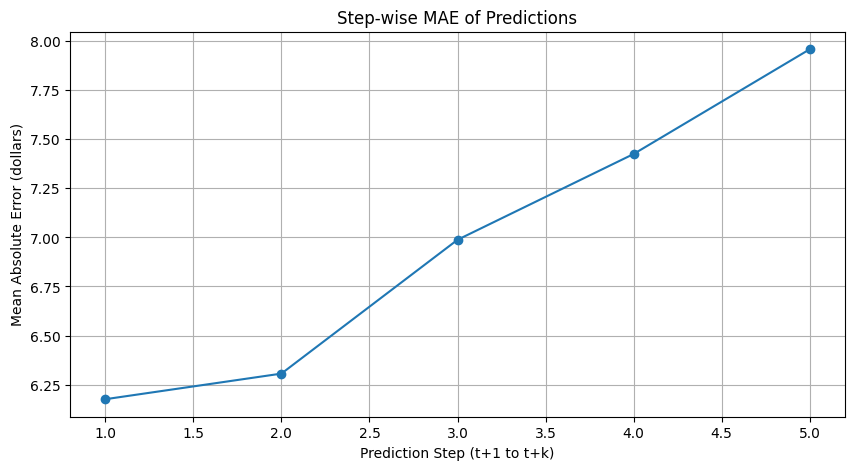

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# preds, y_test đã rescale rồi (preds_rescaled, y_test_rescaled)
# Giả sử: preds_rescaled.shape = (num_samples, k)
#         y_test_rescaled.shape = (num_samples, k)

k = preds_rescaled.shape[1]
step_wise_mae = []

for step in range(k):
    mae = mean_absolute_error(y_test_rescaled[:, step], preds_rescaled[:, step])
    step_wise_mae.append(mae)

# In ra từng step
for i, mae in enumerate(step_wise_mae):
    print(f"Step t+{i+1}: MAE = {mae:.4f} dollars")

# Vẽ biểu đồ MAE theo từng bước
plt.figure(figsize=(10, 5))
plt.plot(range(1, k + 1), step_wise_mae, marker='o')
plt.title("Step-wise MAE of Predictions")
plt.xlabel("Prediction Step (t+1 to t+k)")
plt.ylabel("Mean Absolute Error (dollars)")
plt.grid(True)
plt.show()
